for best practices, I am using type hinting (for functions), modular programming, try and except cases, docstrings for the complex function description.

## 1. Data Preparation

In [194]:
# importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score

In order to handle spreadsheets we need a pip package 'openpyxl' for parsing. For seasonal decomposition of time series we need 'statsmodel' library. 

In [196]:
!pip install openpyxl

In [408]:
!pip install statsmodels

In [197]:
# using load data function to minimize dedundancy
def load_data(filename: str) -> dict[str, pd.DataFrame]:
    """Load all sheets from Excel file into a dictionary of DataFrames"""
    with pd.ExcelFile(filename) as xls:
        return pd.read_excel(xls, sheet_name=None)

    
df = load_data("data_task.xlsx")
order_numbers = df["order_numbers"]
transaction_data = df["transaction_data"]
reported_data = df["reported_data"]

Displaying first 5 rows of each dataset for an initial look

In [198]:
order_numbers.head()

,date,order_number
0,2018-01-07,33841906
1,2018-01-22,34008921
2,2018-01-25,34397468
3,2018-02-06,34434432
4,2018-02-08,34579365


In [199]:
transaction_data.head()

,date,total_spend_index,gross_orders_index,weekly_active_users_index
0,2018-01-01,0.052537,0.158983,1.563652
1,2018-01-02,0.839176,1.430843,1.628314
2,2018-01-03,0.182855,0.476948,1.633740
3,2018-01-04,2.364675,1.907790,1.657706
4,2018-01-05,0.687484,1.271860,1.679863


In [200]:
reported_data.head()

,period,start_date,end_date,revenue_index
0,2018 Q1,2018-01-01,2018-02-28,100.000000
1,2018 Q2,2018-03-01,2018-06-30,253.521127
2,2018 Q3,2018-07-01,2018-08-31,139.788732
3,2018 Q4,2018-09-01,2018-12-31,306.161972
4,2019 Q1,2019-01-01,2019-02-28,117.693662


## 2. Data Cleaning & Transformation
we always start with a copy of the dataset to keep raw data for future use and comparisons.

steps taken to clean and transform data:

- Early data inspection with descriptive statistics
- Exploratory data analysis without cleaning the data
- using line, mean, and seasonal decomposition plot for Visual insights. (explanations given in between cells as a markdown text)
-  

### 2.1 Order Number Sheet

checking for data types and descriptive statistics

In [201]:
order_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          856 non-null    datetime64[ns]
 1   order_number  856 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 KB


In [202]:
order_numbers.describe()

,date,order_number
count,856,8.560000e+02
mean,2020-11-03 20:29:43.177570304,6.118115e+07
min,2018-01-07 00:00:00,8.028800e+04
25%,2019-10-21 12:00:00,4.816847e+07
50%,2020-11-27 00:00:00,6.120493e+07
75%,2021-12-18 06:00:00,7.517348e+07
max,2022-12-30 00:00:00,8.917258e+07
std,NaN,1.752091e+07


In [203]:
# 2. Create clean copy for processing
clean_data = order_numbers.copy()

#### 2.1.1 EDA for order number sheet

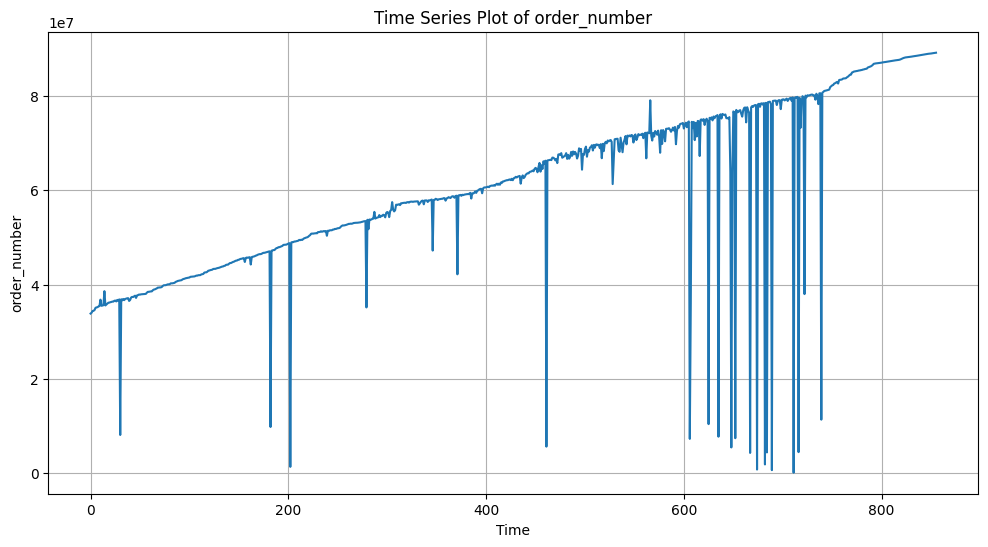

In [204]:
# 1. line plot viz
def plot_time_series(df, column, figsize=(12, 6)) -> None:
    plt.figure(figsize=figsize)
    plt.plot(df.index, df[column])
    plt.title(f'Time Series Plot of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()


plot_time_series(clean_data, 'order_number')

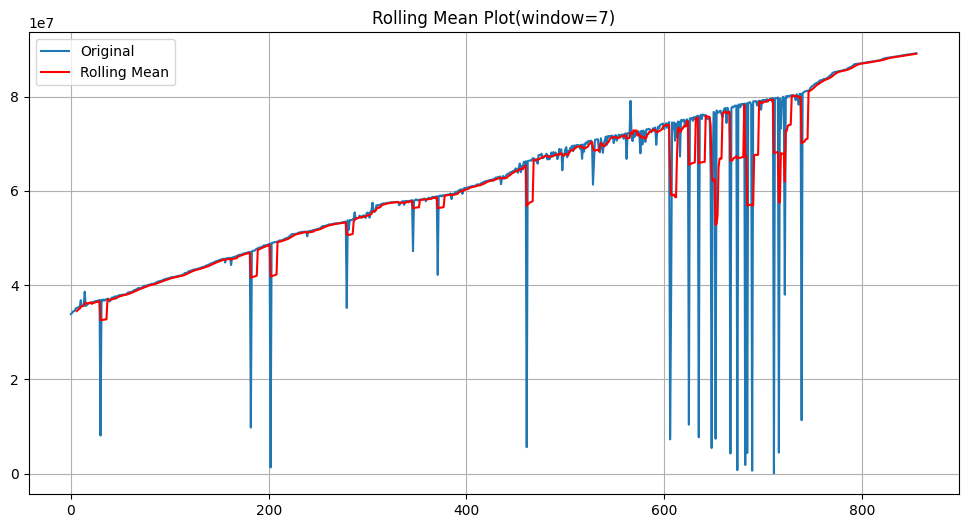

In [205]:
# 2. rolling mean viz
def plot_rolling_stats(df, column, window) -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(df[column], label='Original')
    plt.plot(df[column].rolling(window).mean(), label='Rolling Mean', color='red')
    plt.title(f'Rolling Mean Plot(window={window})')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_rolling_stats(clean_data, 'order_number', window=7)

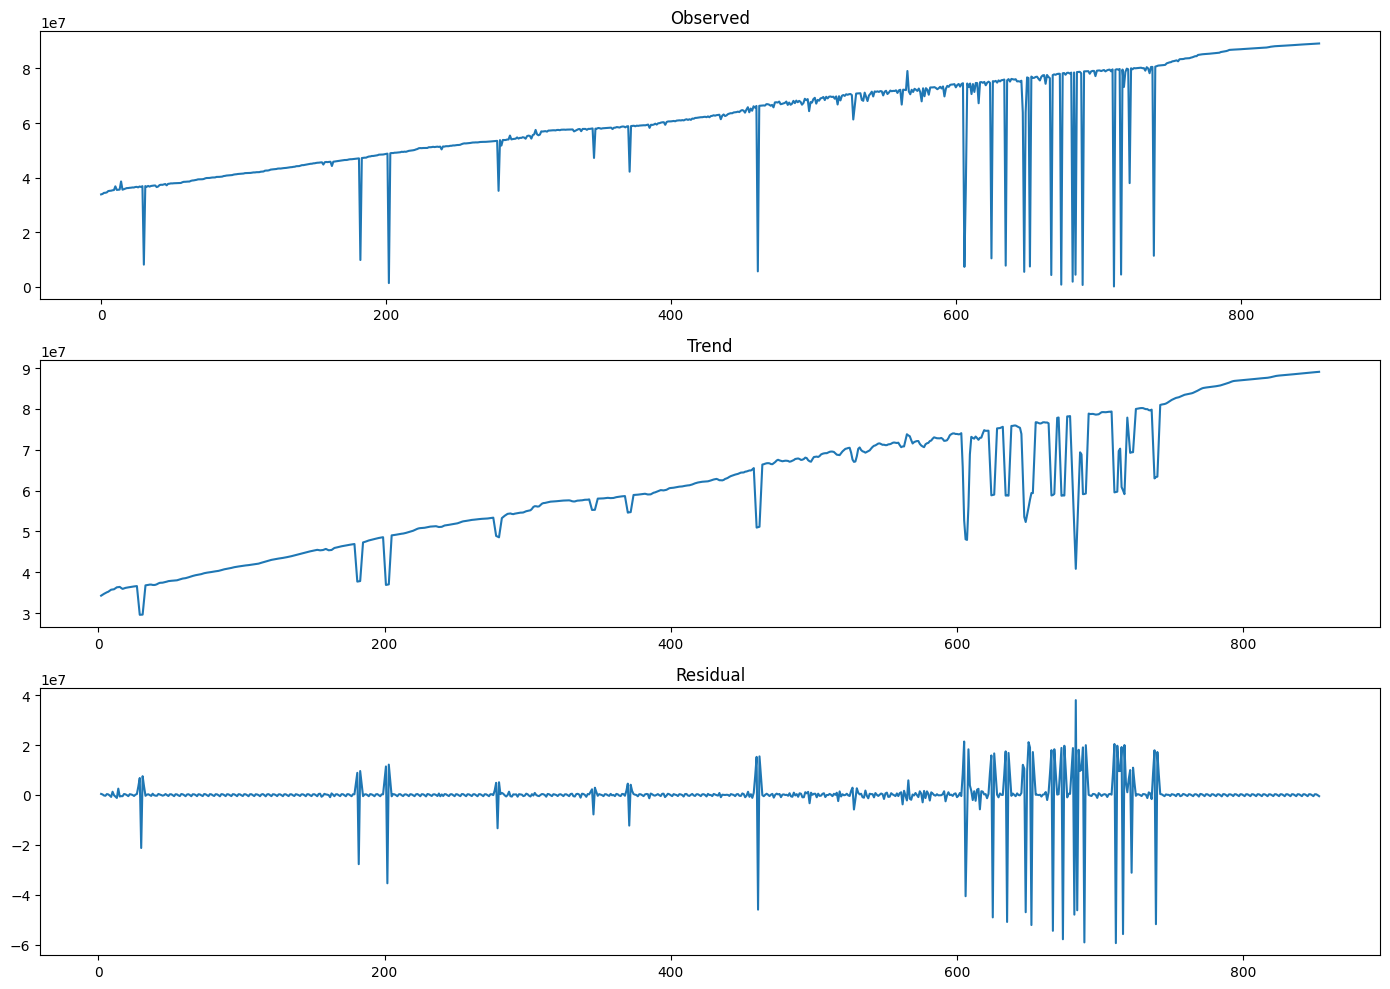

In [206]:
# 3. seasonal decomposition plot
def seasonal_decomposition_plot(df, column, period=4, model='additive', figsize=(12, 8)):
    """
    Enhanced seasonal decomposition plot with adjustable figure size
    
    Parameters:
    - df: DataFrame containing the time series
    - column: Name of column to analyze
    - period: Seasonal period (default=12 for monthly data)
    - model: 'additive' or 'multiplicative' (default='additive')
    - figsize: Tuple specifying figure dimensions (default=(12, 8))
    """
    result = seasonal_decompose(df[column], model=model, period=period)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize)
    
    # Plot each component
    result.observed.plot(ax=ax1, title='Observed')
    result.trend.plot(ax=ax2, title='Trend')
    result.resid.plot(ax=ax3, title='Residual')
    
    plt.tight_layout()
    plt.show()


seasonal_decomposition_plot(clean_data, 'order_number', period=4, figsize=(14, 10))

As we can see through the plots. the 'order_number' column has got abnormal values, when the normal trend is upwards (always incrementing) there is drift in the plot between year 2021 to 2022. To fix this and make sure it always increments we can force order_number values by using 'cummax()' from pandas.

In [207]:
def process_order_series(df) -> pd.DataFrame:
    """
    Complete order number processing pipeline:
    1. Ensures date column exists
    2. Handles duplicate dates
    3. Enforces order_number increment
    4. Fills missing dates by keeping highest order number as the variable is sequential
    5. Provides validation and visualization
    """
    # 1. Ensure date column exists for validation check
    if 'date' not in df.columns:
        df = df.reset_index()
    
    # 2. Handle duplicates by keeping highest order number
    df['date'] = pd.to_datetime(df['date'])
    df = df.groupby('date', as_index=False)['order_number'].max()
    
    # 3. Store original for comparison
    original = df.copy()
    
    # 4. Find decreasing points (before processing)
    decreasing_points = df[df['order_number'].diff() <= 0]
    
    # 5. Enforce increase
    df = df.sort_values('date')
    df['order_number'] = df['order_number'].cummax()
    
    # 6. Handle missing dates
    full_dates = pd.date_range(
        start=df['date'].min(),
        end=df['date'].max(),
        freq='D'
    )
    df = (
        df.set_index('date')
        .reindex(full_dates)
        .ffill()
        .reset_index()
        .rename(columns={'index': 'date'})
    )
    
    # 7. Validation
    is_increasing = df['order_number'].is_monotonic_increasing
    print(f"Final validation:")
    print(f"- Monotonically increasing: {is_increasing}")
    print(f"- Duplicates removed: {len(original) - len(df)}")
    print(f"- Decreasing points corrected: {len(decreasing_points)}")
    
    # 8. Visualization
    plt.figure(figsize=(14, 7))
    plt.plot(df['date'], df['order_number'], 'b-', linewidth=1.5, label='Processed Series')
    
    if not decreasing_points.empty:
        plt.scatter(
            decreasing_points['date'],
            decreasing_points['order_number'],
            c='red', s=50, marker='x',
            label=f'Corrected Points ({len(decreasing_points)})'
        )
    
    plt.title("Order Number Processing Results", pad=15)
    plt.xlabel("Date")
    plt.ylabel("Order Number")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return df

Final validation:
- Monotonically increasing: True
- Duplicates removed: -1079
- Decreasing points corrected: 158


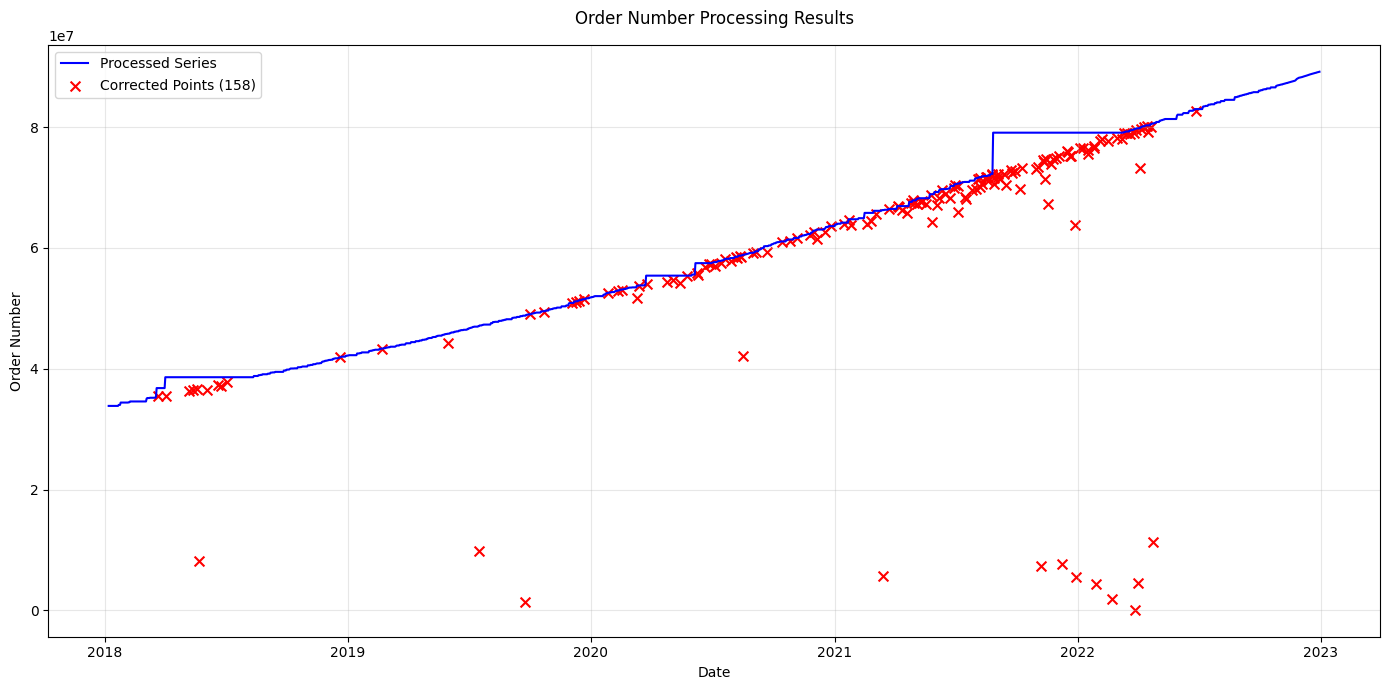

In [208]:
# Process raw data copy that was made earlier
order_numbers_processed = process_order_series(clean_data)

The blue line shows the processed order_number which moves the red points upwards to always keep an increment. this creates a baseline for our order number data. 

In [209]:
order_numbers_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1819 non-null   datetime64[ns]
 1   order_number  1819 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.5 KB


Visualizing again for comparison. Now we can see a clear line plot with less noise and always moving upwards.

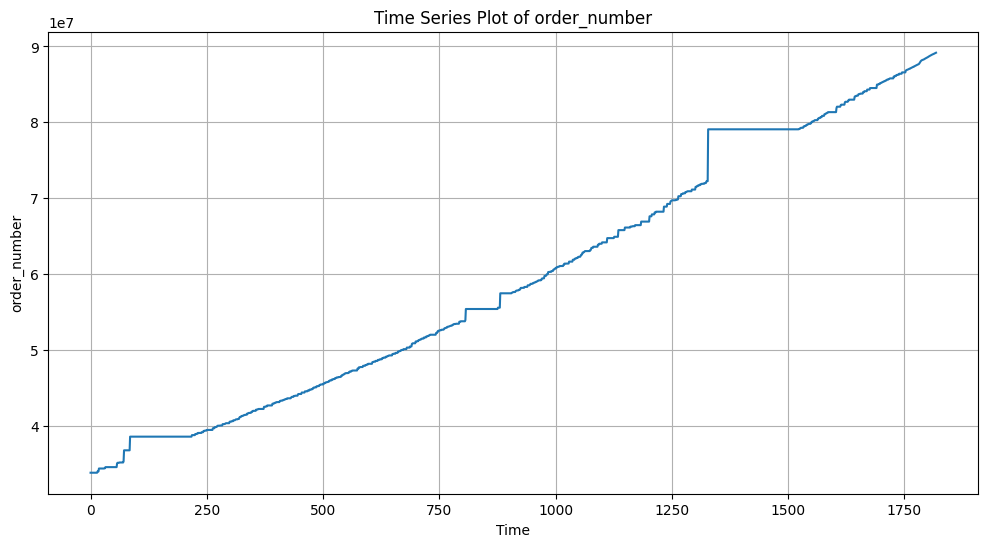

In [210]:
# 1. line plot
plot_time_series(order_numbers_processed, 'order_number')

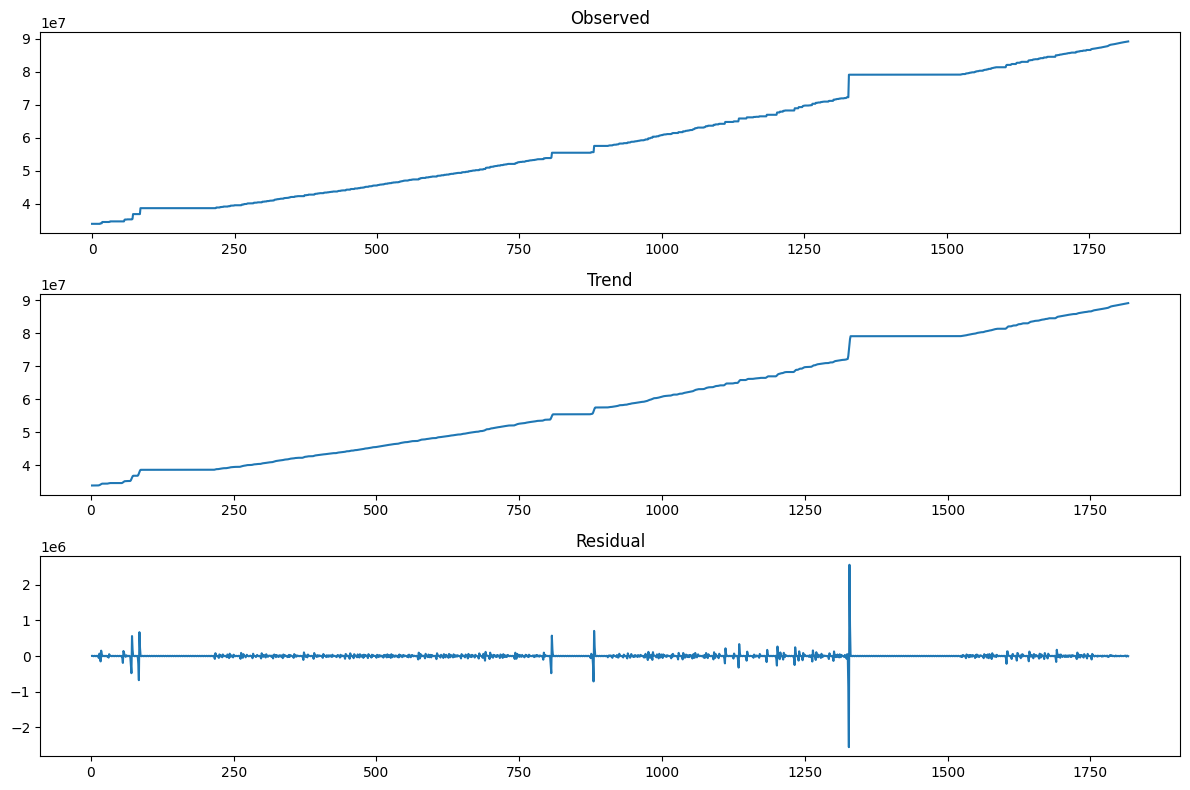

In [211]:
# 2. seasonality decomposition
seasonal_decomposition_plot(order_numbers_processed, 'order_number', period=4)

Now we can notice the long term increment trend and minimal residual pattern after data preprocessing (cleaning and transformation)

#### 2.2 Transaction Data Sheet

checking for data types and descriptive statistics

In [212]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       1826 non-null   datetime64[ns]
 1   total_spend_index          1826 non-null   float64       
 2   gross_orders_index         1826 non-null   float64       
 3   weekly_active_users_index  1826 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 57.2 KB


In [213]:
transaction_data.describe()

,date,total_spend_index,gross_orders_index,weekly_active_users_index
count,1826,1826.000000,1826.000000,1826.000000
mean,2020-07-01 12:00:00,114.415785,119.426078,113.916658
min,2018-01-01 00:00:00,0.000000,0.000000,1.563652
25%,2019-04-02 06:00:00,15.502885,16.096979,28.620862
50%,2020-07-01 12:00:00,63.874947,68.600954,117.443217
75%,2021-09-30 18:00:00,190.802040,204.093800,196.806339
max,2022-12-31 00:00:00,1312.774732,1346.263911,237.144188
std,NaN,130.486414,134.581906,83.514286


#### 2.2 Reported Data Sheet

checking for data types and descriptive statistics

In [214]:
reported_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   period         20 non-null     object        
 1   start_date     20 non-null     datetime64[ns]
 2   end_date       20 non-null     datetime64[ns]
 3   revenue_index  20 non-null     float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 768.0+ bytes


As we can see the data type of 'period' column is 'object' which can be misinterpreted during the analysis. We can use pandas 'PeriodIndex' to handle quarterly data intelligently.

In [215]:
# converting period dtype object to periodIndex
reported_data['period'] = reported_data['period'].str.replace(' ', '')
reported_data['period'] = pd.PeriodIndex(reported_data['period'], freq='Q')

In [216]:
reported_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   period         20 non-null     period[Q-DEC] 
 1   start_date     20 non-null     datetime64[ns]
 2   end_date       20 non-null     datetime64[ns]
 3   revenue_index  20 non-null     float64       
dtypes: datetime64[ns](2), float64(1), period[Q-DEC](1)
memory usage: 768.0 bytes


Now the datatype has been changed to 'period[Q-Dec]'

In [217]:
reported_data.describe()

,start_date,end_date,revenue_index
count,20,20,20.000000
mean,2020-04-29 19:12:00,2020-07-29 02:24:00,291.340869
min,2018-01-01 00:00:00,2018-02-28 00:00:00,100.000000
25%,2019-02-14 06:00:00,2019-05-30 12:00:00,201.738556
50%,2020-05-01 00:00:00,2020-07-31 00:00:00,271.654930
75%,2021-07-16 12:00:00,2021-09-30 12:00:00,372.243807
max,2022-09-01 00:00:00,2022-12-31 00:00:00,552.442986
std,NaN,NaN,136.115147


## 3. Feature Engineering

### Order Metrics
- **`daily_orders`**: Raw daily order volume (`order_number.diff()`)
- **`order_growth_7d/30d`**: Smoothed growth rates (`diff(7)/7` and `diff(30)/30`)

### Transaction Metrics
- **`spend_per_order`**: Total spend ÷ gross orders
- **`user_engagement`**: Gross orders ÷ active users


### Aggregation Methodology

### Daily → Quarterly Conversion

### Key Aggregations
| Metric Type | Aggregation | Example Features |
|-------------|-------------|------------------|
| **Volume Metrics** | `sum()` | `orders_sum` |
| **Rate Metrics** | `mean()` | `growth_7d_mean`, `spend_per_order_mean` |
| **Index Values** | `mean()` | `spend_index_mean`, `users_index_mean` |



In [218]:
# Check date ranges and formats
print("Order numbers dates:", order_numbers['date'].min(), "to", order_numbers['date'].max())
print("Reported data dates:", reported_data['start_date'].min(), "to", reported_data['start_date'].max())

Order numbers dates: 2018-01-07 00:00:00 to 2022-12-30 00:00:00
Reported data dates: 2018-01-01 00:00:00 to 2022-09-01 00:00:00


In [219]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2019-01-01 to 2022-09-01
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   period                16 non-null     period[Q-DEC] 
 1   revenue_index         16 non-null     float64       
 2   end_date              16 non-null     datetime64[ns]
 3   orders_sum            16 non-null     float64       
 4   orders_mean           16 non-null     float64       
 5   growth_7d_mean        16 non-null     float64       
 6   growth_30d_mean       16 non-null     float64       
 7   spend_index_mean      16 non-null     float64       
 8   users_index_mean      16 non-null     float64       
 9   spend_per_order_mean  16 non-null     float64       
 10  user_engagement_mean  16 non-null     float64       
 11  days_in_period        16 non-null     int64         
dtypes: datetime64[ns](1), float64(9), int64(1), period[Q-DEC](1)

In [220]:
def prepare_features(order_numbers, transaction_data, reported_data) -> pd.DataFrame:
    """feature engineering pipeline"""
    try:
        # 1. Convert and validate inputs
        order_numbers = order_numbers.copy()
        transaction_data = transaction_data.copy()
        reported_data = reported_data.copy()
        
        # Convert dates
        order_numbers['date'] = pd.to_datetime(order_numbers['date'])
        transaction_data['date'] = pd.to_datetime(transaction_data['date'])
        reported_data['start_date'] = pd.to_datetime(reported_data['start_date'])
        reported_data['end_date'] = pd.to_datetime(reported_data['end_date'])
        
        # 2. Remove duplicates
        order_numbers = order_numbers.drop_duplicates('date', keep='last')
        transaction_data = transaction_data.drop_duplicates('date', keep='last')
        
        # 3. Create complete date range
        full_dates = pd.date_range(
            start=min(order_numbers['date'].min(), transaction_data['date'].min()),
            end=max(order_numbers['date'].max(), transaction_data['date'].max()),
            freq='D'
        )
        
        # 4. Process order data
        daily_orders = (
            order_numbers.set_index('date')
            .reindex(full_dates)
            .assign(
                order_number=lambda x: x['order_number'].ffill(),
                daily_orders=lambda x: x['order_number'].diff().fillna(0),
                order_growth_7d=lambda x: x['order_number'].diff(7)/7,
                order_growth_30d=lambda x: x['order_number'].diff(30)/30
            )
        )
        
        # 5. Process transaction data
        daily_trans = (
            transaction_data.set_index('date')
            .reindex(full_dates)
            .assign(
                total_spend_index=lambda x: x['total_spend_index'].ffill(),
                gross_orders_index=lambda x: x['gross_orders_index'].ffill(),
                weekly_active_users_index=lambda x: x['weekly_active_users_index'].ffill()
            )
            .assign(
                spend_per_order=lambda x: x['total_spend_index']/x['gross_orders_index'],
                user_engagement=lambda x: x['gross_orders_index']/x['weekly_active_users_index']
            )
        )
        
        # 6. Aggregate by reporting period
        features = []
        for _, period in reported_data.iterrows():
            start = period['start_date']
            end = period['end_date']
            
            # Aggregate features
            features.append({
                'period': period['period'],
                'revenue_index': period['revenue_index'],
                'start_date': start,
                'end_date': end,
                'orders_sum': daily_orders.loc[start:end]['daily_orders'].sum(),
                'orders_mean': daily_orders.loc[start:end]['daily_orders'].mean(),
                'growth_7d_mean': daily_orders.loc[start:end]['order_growth_7d'].mean(),
                'growth_30d_mean': daily_orders.loc[start:end]['order_growth_30d'].mean(),
                'spend_index_mean': daily_trans.loc[start:end]['total_spend_index'].mean(),
                'users_index_mean': daily_trans.loc[start:end]['weekly_active_users_index'].mean(),
                'spend_per_order_mean': daily_trans.loc[start:end]['spend_per_order'].mean(),
                'user_engagement_mean': daily_trans.loc[start:end]['user_engagement'].mean(),
                'days_in_period': (end - start).days + 1
            })
        
        # 7. Create final DataFrame
        features_df = pd.DataFrame(features).set_index('start_date')
        print("Successfully created features with shape:", features_df.shape)
        return features_df
        
    except Exception as e:
        print(f"Error in prepare_features: {str(e)}")
        # Return empty DataFrame with expected columns
        return pd.DataFrame(columns=['period', 'revenue_index', 'end_date', 'orders_sum', 
                                   'orders_mean', 'growth_7d_mean', 'growth_30d_mean',
                                   'spend_index_mean', 'users_index_mean', 
                                   'spend_per_order_mean', 'user_engagement_mean',
                                   'days_in_period']).set_index('start_date', drop=False)


features = prepare_features(order_numbers, transaction_data, reported_data)
X = features.drop(columns=['period', 'end_date', 'revenue_index'])
y = features['revenue_index']

Successfully created features with shape: (20, 12)


## 4. Model Building and Evaluation

For model building, I made use of pipeline() from scikit learn. first standardizing the dataset to fall within a fixed range to later feed this to RandomForestRegressor. 

#### Model Selection: Why Random Forest?

#### Key Advantages for This Use Case

#### 1. Handles Mixed Features Well
   - Automatically works with:
     - Trend features (`growth_7d_mean`)
     - Volume metrics (`orders_sum`)
     - Ratios (`spend_per_order_mean`)

for more resource intensive data, the choice could've been between ARIMA and SARIMA depnding upon the type of data seasonal or not. For this task it was either xgboost or randomforestregressor. I tried xgboost but the prediction of revenue_index was not a good fit.

In [221]:
def build_model():
    """Configure the prediction pipeline"""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=150,
            max_depth=4,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ))
    ])

In [222]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Comprehensive model evaluation"""
    # Train metrics
    train_pred = model.predict(X_train)
    train_metrics = {
        'train_r2': r2_score(y_train, train_pred),
        'train_mae': mean_absolute_error(y_train, train_pred)
    }
    
    # Test metrics (if test data exists)
    test_metrics = {}
    if len(X_test) > 0:
        test_pred = model.predict(X_test)
        test_metrics = {
            'test_r2': r2_score(y_test, test_pred),
            'test_mae': mean_absolute_error(y_test, test_pred),
            'test_pe': np.mean(np.abs((y_test - test_pred)/y_test)) * 100,
            'prediction': test_pred[0] if len(test_pred) == 1 else test_pred,
            'actual': y_test.iloc[0] if len(y_test) > 0 else None
        }
    
    return {**train_metrics, **test_metrics}

### 5. Main File Section

Preparing features...
Successfully created features with shape: (20, 12)
Using 16 periods for modeling

Training model...

Model Performance Evaluation
In-sample R-squared: 0.917
In-sample MAE: 30.96 index points

Top Predictive Features:
                feature  importance
8        days_in_period    0.458240
7  user_engagement_mean    0.303382
4      spend_index_mean    0.064257
1           orders_mean    0.054629
6  spend_per_order_mean    0.039553
0            orders_sum    0.031165
5      users_index_mean    0.021277
3       growth_30d_mean    0.018829
2        growth_7d_mean    0.008667


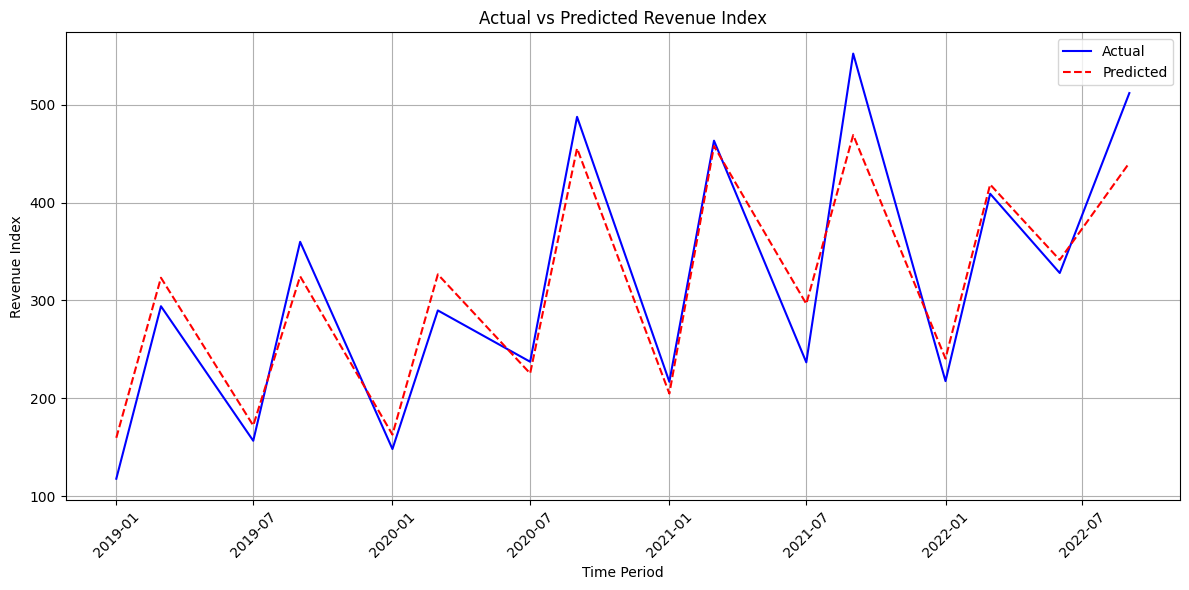

In [223]:
# main
# 1. Prepare features
print("Preparing features...")
features = prepare_features(order_numbers, transaction_data, reported_data)

if features.empty:
    print("Error: No features generated - check data inputs")
    exit()

# 2. Filter to relevant periods (2019 onwards)
features = features[features.index >= pd.to_datetime('2019-01-01')]
print(f"Using {len(features)} periods for modeling")

# 3. Prepare modeling data
X = features.drop(columns=['period', 'end_date', 'revenue_index'])
y = features['revenue_index']

# 4. Train-test split (2022 Q4 as test)
train_mask = features.index <= pd.to_datetime('2022-09-30')  # All data up to 2022 Q3
test_mask = features.index > pd.to_datetime('2022-09-30')    # 2022 Q4

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# 5. Build and evaluate model
print("\nTraining model...")
model = build_model()
model.fit(X_train, y_train) 
metrics = evaluate_model(model, X_train, X_test, y_train, y_test)

# 6. Display results
print("\nModel Performance Evaluation")
print("============================")
print(f"In-sample R-squared: {metrics['train_r2']:.3f}")
print(f"In-sample MAE: {metrics['train_mae']:.2f} index points")

if 'test_mae' in metrics:
    print(f"\n2022 Q4 Test Results:")
    print(f"- Actual: {metrics['actual']:.1f}")
    print(f"- Predicted: {metrics['prediction']:.1f}")
    print(f"- MAE: {metrics['test_mae']:.2f} index points")
    print(f"- Percentage Error: {metrics['test_pe']:.1f}%")
    
    # NEW: Detailed quarter-by-quarter test results
    print("\nQuarterly Test Performance Breakdown:")
    test_data = features[test_mask].copy()
    test_data['prediction'] = model.predict(X_test)
    test_data['error'] = test_data['revenue_index'] - test_data['prediction']
    test_data['abs_error'] = test_data['error'].abs()
    test_data['pct_error'] = (test_data['abs_error'] / test_data['revenue_index']) * 100
    
    for idx, row in test_data.iterrows():
        print(f"\n{idx.strftime('%Y-Q%q')}:")
        print(f"  Actual: {row['revenue_index']:.1f}")
        print(f"  Predicted: {row['prediction']:.1f}")
        print(f"  Error: {row['error']:.1f} ({row['pct_error']:.1f}%)")

# 7. Feature importance
try:
    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': model.named_steps['model'].feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop Predictive Features:")
    print(importances.head(10))
    
    
except Exception as e:
    print(f"\nCould not extract feature importance: {str(e)}")

# 8. Plot predictions
if len(features) > 4:  # Only plot if sufficient data
    # NEW: Enhanced plotting with test set highlighted
    plt.figure(figsize=(12, 6))
    plt.plot(features.index, y, 'b-', label='Actual')
    plt.plot(features.index, model.predict(X), 'r--', label='Predicted')
    
    
    plt.title('Actual vs Predicted Revenue Index')
    plt.xlabel('Time Period')
    plt.ylabel('Revenue Index')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

The predicted results vs the Actual values are a close match. for performance evaluation, the two required metrics R-squared and Mean Absolute Error shows no signs of overfitting. 

for further improvements, we can do residual analysis and based on feature importance we can fit the model close to the actual values by changing the models hyperparameters or performing correlation analysis for more robust feature selection and importance. 

Depending upon the data and features complexity we can use either classical methods like Regression, ARIMA & SARIMA or we can move towards deep learning model like LSTM, RNN which can extract more complex patterns from sequence datasets. 

Th model comparison was out of scope for this task so, I went with randomforest because of the reasons mentioned in its owm section.